In [ ]:
!pip install wandb

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm



In [2]:
import wandb

wandb.init(project="finetuning")

wandb: Currently logged in as: vrinda19. Use `wandb login --relogin` to force relogin


In [3]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train=torchvision.datasets.CIFAR10("./data",train=True,download=True,transform=transform)
train,val=torch.utils.data.random_split(train,[45000,5000])
trainloader=torch.utils.data.DataLoader(train,shuffle=True,batch_size=32,num_workers=2)
valloader=torch.utils.data.DataLoader(val,shuffle=False,batch_size=32,num_workers=2)
test=torchvision.datasets.CIFAR10("./data",train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(test,shuffle=False,batch_size=32,num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


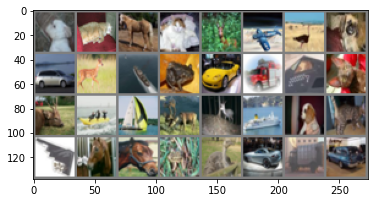

dog   cat   horse cat   deer  plane bird  dog   car   deer  ship  frog  car   truck plane cat   deer  ship  ship  deer  deer  ship  dog   cat   plane horse horse frog  bird  car   truck car  


In [4]:
#vizualize images of each class

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

  

In [5]:
#LeNet-5 architecture
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
    self.dropout = nn.Dropout(0.4)
    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
    self.fc1=nn.Linear(16*5*5,120)#???
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x =  self.dropout(x)
    x = F.avg_pool2d(x,2,2) 
    x = F.relu(self.conv2(x))
    x =  self.dropout(x)
    x = F.avg_pool2d(x, 2, 2)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x =  self.dropout(x)
    x = F.relu(self.fc2(x))
    x=  self.dropout(x)
    x = self.fc3(x)
    
    return x
ConvNet() 



ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import os
def train(net,trainloader,epoch,filename,path):
  loss=nn.CrossEntropyLoss()
  optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.001)
  device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
  net.to(device)
  
  total_loss=0
  correct_pred=0
  total_vl=0
  correct_vl=0
  
  t_acc=[]
  t_ls=[]
  v_ls=[]
  v_acc=[]
  wandb.define_metric("epoch")
  wandb.define_metric("train_loss", step_metric = "epoch")
  wandb.define_metric("valid_loss", step_metric = "epoch")
  wandb.define_metric("train_accuracy", step_metric = "epoch")
  wandb.define_metric("valid_accuracy", step_metric = "epoch")

  min_valid_loss=np.inf #positive infinity
  if not(os.path.exists(path)):
      os.makedirs(path)
  best_fname='best_'+filename
  fname=os.path.join(path,filename)
  best_fname=os.path.join(path,best_fname)

  for epoch in tqdm(range(epoch)):
    net.train()
    loss_epoch=0
    val_loss_epoch=0
    for xtrain,ytrain in trainloader:
      xtrain=xtrain.to(device)
      ytrain=ytrain.to(device)
      net.zero_grad()

      ypredtrain=net(xtrain)
      trainloss=loss(ypredtrain,ytrain)
      loss_epoch+=trainloss.item() #loss.item() contains the loss of the entire mini-batch
      trainloss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _,predicted=ypredtrain.max(1)
      total_loss+=ytrain.size(0)
      correct_pred+=predicted.eq(ytrain).sum().item()

    print("Epoch",int(epoch))
    epoch_loss=round(loss_epoch/len(trainloader),2)
    print("Training data loss",epoch_loss)

    epoch_accuracy=round(100*correct_pred/total_loss,2)
    print("Accuracy is",epoch_accuracy)
    t_acc.append(epoch_accuracy)
    t_ls.append(epoch_loss)
    wandb.log({"train_loss": epoch_loss})
    wandb.log({"train_accuracy": epoch_accuracy})
    wandb.log({'epoch':epoch+1})   

    net.eval()
    with torch.no_grad():
      for xval,yval in valloader:
        
        xval=xval.to(device)
        yval=yval.to(device)

        ypredval=net(xval)
        valloss=loss(ypredval,yval)
        val_loss_epoch+=valloss.item() #loss.item() contains the loss of the entire mini-batch
        _, predicted = ypredval.max(1)
        total_vl += yval.size(0)
        correct_vl += predicted.eq(yval).sum().item()
      v_ep_loss = round(val_loss_epoch/len(valloader),2)
      print('\tValidation loss',v_ep_loss )
      v_ep_acc = round(100.*correct_vl/total_vl, 2)
      print('\tValidation Accuracy',v_ep_acc)
      v_ls.append(v_ep_loss)
      v_acc.append(v_ep_acc)

      wandb.log({"valid_loss": v_ep_loss})
      wandb.log({"val_accuracy": v_ep_acc})
      wandb.log({'epoch':epoch+1})

    if min_valid_loss>v_ep_acc:
      print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{v_ep_loss:.6f})')
      print("saving best model",best_fname)
      min_valid_loss=v_ep_acc
      torch.save(net.state_dict(),best_fname)


  print('--Finished Training')
  print('--Model saved to ', fname)
  print('--Best model saved to', best_fname)
      
  #loss plotter for train and validation 
  plt.title('Cross Entropy Loss {}'.format(type(net).__name__))
  plt.xlabel('Epoch')
 
  plt.plot(t_ls,label="train")
  plt.plot(v_ls, label="valid")
  plt.legend()
  fname = 'Train Cross Entropy Loss {}'.format(type(net).__name__) + '.eps'
  fname = os.path.join(path, fname)
  plt.savefig(fname, format='eps')
  plt.show()

  #accuracy plotter for train and validation
  plt.title('Accuracy {}'.format(type(net).__name__))
  plt.xlabel('Epoch')

  plt.plot(t_acc,label="train")
  plt.plot(v_acc, label='valid' )
  plt.legend()
  
  fname = 'Train Accuracy {}'.format(type(net).__name__) + '.eps'
  fname = os.path.join(path, fname)
  plt.savefig(fname, format='eps')
  plt.show()



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0
Training data loss 1.81
Accuracy is 32.86


  2%|▏         | 1/50 [00:25<20:26, 25.03s/it]

	Validation loss 1.56
	Validation Accuracy 43.22
Validation Loss Decreased(inf--->1.560000)
saving best model ./weights/check_convnet/best_check_convnet.pth
Epoch 1
Training data loss 1.58
Accuracy is 37.76


  4%|▍         | 2/50 [00:45<17:42, 22.14s/it]

	Validation loss 1.45
	Validation Accuracy 45.39
Epoch 2
Training data loss 1.51
Accuracy is 40.45


  6%|▌         | 3/50 [01:04<16:27, 21.00s/it]

	Validation loss 1.4
	Validation Accuracy 46.5
Epoch 3
Training data loss 1.47
Accuracy is 42.24


  8%|▊         | 4/50 [01:26<16:13, 21.16s/it]

	Validation loss 1.38
	Validation Accuracy 47.52
Epoch 4
Training data loss 1.43
Accuracy is 43.62


 10%|█         | 5/50 [01:45<15:26, 20.60s/it]

	Validation loss 1.32
	Validation Accuracy 48.41
Epoch 5
Training data loss 1.41
Accuracy is 44.65


 12%|█▏        | 6/50 [02:06<15:04, 20.55s/it]

	Validation loss 1.31
	Validation Accuracy 49.17
Epoch 6
Training data loss 1.39
Accuracy is 45.51


 14%|█▍        | 7/50 [02:25<14:29, 20.23s/it]

	Validation loss 1.29
	Validation Accuracy 49.67
Epoch 7
Training data loss 1.38
Accuracy is 46.22


 16%|█▌        | 8/50 [02:45<14:01, 20.04s/it]

	Validation loss 1.25
	Validation Accuracy 50.24
Epoch 8
Training data loss 1.36
Accuracy is 46.83


 18%|█▊        | 9/50 [03:05<13:36, 19.91s/it]

	Validation loss 1.24
	Validation Accuracy 50.82
Epoch 9
Training data loss 1.36
Accuracy is 47.38


 20%|██        | 10/50 [03:25<13:21, 20.05s/it]

	Validation loss 1.24
	Validation Accuracy 51.32
Epoch 10
Training data loss 1.35
Accuracy is 47.82


 22%|██▏       | 11/50 [03:44<12:55, 19.88s/it]

	Validation loss 1.21
	Validation Accuracy 51.82
Epoch 11
Training data loss 1.33
Accuracy is 48.24


 24%|██▍       | 12/50 [04:04<12:31, 19.78s/it]

	Validation loss 1.24
	Validation Accuracy 52.19
Epoch 12
Training data loss 1.33
Accuracy is 48.63


 26%|██▌       | 13/50 [04:23<12:07, 19.65s/it]

	Validation loss 1.19
	Validation Accuracy 52.64
Epoch 13
Training data loss 1.32
Accuracy is 48.98


 28%|██▊       | 14/50 [04:44<11:53, 19.81s/it]

	Validation loss 1.18
	Validation Accuracy 53.01
Epoch 14
Training data loss 1.3
Accuracy is 49.35


 30%|███       | 15/50 [05:03<11:29, 19.70s/it]

	Validation loss 1.19
	Validation Accuracy 53.3
Epoch 15
Training data loss 1.29
Accuracy is 49.67


 32%|███▏      | 16/50 [05:22<11:08, 19.65s/it]

	Validation loss 1.16
	Validation Accuracy 53.62
Epoch 16
Training data loss 1.29
Accuracy is 49.97


 34%|███▍      | 17/50 [05:42<10:50, 19.71s/it]

	Validation loss 1.15
	Validation Accuracy 53.95
Epoch 17
Training data loss 1.28
Accuracy is 50.25


 36%|███▌      | 18/50 [06:02<10:34, 19.83s/it]

	Validation loss 1.13
	Validation Accuracy 54.25
Epoch 18
Training data loss 1.28
Accuracy is 50.51


 38%|███▊      | 19/50 [06:22<10:12, 19.75s/it]

	Validation loss 1.15
	Validation Accuracy 54.5
Epoch 19
Training data loss 1.28
Accuracy is 50.75


 40%|████      | 20/50 [06:41<09:48, 19.63s/it]

	Validation loss 1.13
	Validation Accuracy 54.78
Epoch 20
Training data loss 1.27
Accuracy is 50.99


 42%|████▏     | 21/50 [07:01<09:28, 19.61s/it]

	Validation loss 1.13
	Validation Accuracy 55.03
Epoch 21
Training data loss 1.26
Accuracy is 51.21


 44%|████▍     | 22/50 [07:20<09:05, 19.48s/it]

	Validation loss 1.15
	Validation Accuracy 55.23
Epoch 22
Training data loss 1.26
Accuracy is 51.41


 46%|████▌     | 23/50 [07:39<08:45, 19.45s/it]

	Validation loss 1.13
	Validation Accuracy 55.45
Epoch 23
Training data loss 1.25
Accuracy is 51.62


 48%|████▊     | 24/50 [07:59<08:23, 19.35s/it]

	Validation loss 1.1
	Validation Accuracy 55.69
Epoch 24
Training data loss 1.25
Accuracy is 51.8


 50%|█████     | 25/50 [08:18<08:03, 19.32s/it]

	Validation loss 1.13
	Validation Accuracy 55.85
Epoch 25
Training data loss 1.24
Accuracy is 51.99


 52%|█████▏    | 26/50 [08:37<07:42, 19.29s/it]

	Validation loss 1.12
	Validation Accuracy 55.99
Epoch 26
Training data loss 1.23
Accuracy is 52.18


 54%|█████▍    | 27/50 [08:56<07:23, 19.28s/it]

	Validation loss 1.12
	Validation Accuracy 56.15
Epoch 27
Training data loss 1.23
Accuracy is 52.35


 56%|█████▌    | 28/50 [09:16<07:09, 19.52s/it]

	Validation loss 1.1
	Validation Accuracy 56.32
Epoch 28
Training data loss 1.24
Accuracy is 52.5


 58%|█████▊    | 29/50 [09:36<06:48, 19.48s/it]

	Validation loss 1.14
	Validation Accuracy 56.42
Epoch 29
Training data loss 1.23
Accuracy is 52.65


 60%|██████    | 30/50 [09:55<06:28, 19.43s/it]

	Validation loss 1.11
	Validation Accuracy 56.55
Epoch 30
Training data loss 1.23
Accuracy is 52.79


 62%|██████▏   | 31/50 [10:14<06:08, 19.40s/it]

	Validation loss 1.1
	Validation Accuracy 56.7
Epoch 31
Training data loss 1.23
Accuracy is 52.93


 64%|██████▍   | 32/50 [10:35<05:53, 19.65s/it]

	Validation loss 1.09
	Validation Accuracy 56.85
Epoch 32
Training data loss 1.22
Accuracy is 53.06


 66%|██████▌   | 33/50 [10:54<05:33, 19.59s/it]

	Validation loss 1.08
	Validation Accuracy 57.0
Epoch 33
Training data loss 1.22
Accuracy is 53.19


 68%|██████▊   | 34/50 [11:13<05:11, 19.47s/it]

	Validation loss 1.09
	Validation Accuracy 57.13
Epoch 34
Training data loss 1.22
Accuracy is 53.32


 70%|███████   | 35/50 [11:33<04:51, 19.43s/it]

	Validation loss 1.09
	Validation Accuracy 57.24
Epoch 35
Training data loss 1.22
Accuracy is 53.43


 72%|███████▏  | 36/50 [11:52<04:33, 19.56s/it]

	Validation loss 1.07
	Validation Accuracy 57.39
Epoch 36
Training data loss 1.21
Accuracy is 53.55


 74%|███████▍  | 37/50 [12:12<04:12, 19.40s/it]

	Validation loss 1.08
	Validation Accuracy 57.51
Epoch 37
Training data loss 1.21
Accuracy is 53.67


 76%|███████▌  | 38/50 [12:30<03:51, 19.27s/it]

	Validation loss 1.08
	Validation Accuracy 57.61
Epoch 38
Training data loss 1.21
Accuracy is 53.78


 78%|███████▊  | 39/50 [12:50<03:33, 19.45s/it]

	Validation loss 1.07
	Validation Accuracy 57.73
Epoch 39
Training data loss 1.21
Accuracy is 53.88


 80%|████████  | 40/50 [13:10<03:13, 19.37s/it]

	Validation loss 1.05
	Validation Accuracy 57.87
Epoch 40
Training data loss 1.21
Accuracy is 53.98


 82%|████████▏ | 41/50 [13:29<02:54, 19.36s/it]

	Validation loss 1.06
	Validation Accuracy 57.97
Epoch 41
Training data loss 1.2
Accuracy is 54.09


 84%|████████▍ | 42/50 [13:48<02:34, 19.32s/it]

	Validation loss 1.05
	Validation Accuracy 58.09
Epoch 42
Training data loss 1.21
Accuracy is 54.18


 86%|████████▌ | 43/50 [14:08<02:17, 19.58s/it]

	Validation loss 1.06
	Validation Accuracy 58.21
Epoch 43
Training data loss 1.2
Accuracy is 54.28


 88%|████████▊ | 44/50 [14:28<01:56, 19.50s/it]

	Validation loss 1.06
	Validation Accuracy 58.32
Epoch 44
Training data loss 1.2
Accuracy is 54.37


 90%|█████████ | 45/50 [14:47<01:37, 19.44s/it]

	Validation loss 1.06
	Validation Accuracy 58.43
Epoch 45
Training data loss 1.2
Accuracy is 54.46


 92%|█████████▏| 46/50 [15:06<01:17, 19.38s/it]

	Validation loss 1.06
	Validation Accuracy 58.51
Epoch 46
Training data loss 1.19
Accuracy is 54.55


 94%|█████████▍| 47/50 [15:26<00:58, 19.59s/it]

	Validation loss 1.08
	Validation Accuracy 58.59
Epoch 47
Training data loss 1.2
Accuracy is 54.63


 96%|█████████▌| 48/50 [15:45<00:38, 19.45s/it]

	Validation loss 1.07
	Validation Accuracy 58.66
Epoch 48
Training data loss 1.2
Accuracy is 54.71


 98%|█████████▊| 49/50 [16:04<00:19, 19.35s/it]

	Validation loss 1.08
	Validation Accuracy 58.72
Epoch 49
Training data loss 1.19
Accuracy is 54.79


100%|██████████| 50/50 [16:24<00:00, 19.69s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


	Validation loss 1.04
	Validation Accuracy 58.81
--Finished Training
--Model saved to  ./weights/check_convnet/check_convnet.pth
--Best model saved to ./weights/check_convnet/best_check_convnet.pth


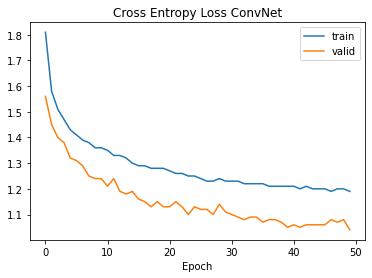

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


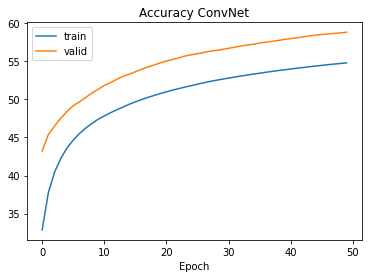

In [7]:
model_cnn = ConvNet()
wandb.watch(model_cnn, log="all", log_freq=10)

train(model_cnn, trainloader, epoch = 50, path = './weights/check_convnet/', filename = 'check_convnet.pth')

In [9]:
#create STL dataset

transform_stl=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
     transforms.Resize([int(32),int(32)])])

In [10]:
#stl dataset with only 5 classes
#STL10 dataset
def get_same_index(target,classes_req):
  label_indices=[]
  for i in range (len(target)):
    for j in classes_req:
      if target[i]==j:
        label_indices.append(i)
  return label_indices

train_stl=torchvision.datasets.STL10(root='./data',
                                           transform=transform_stl,split='train',download=True)
#cifar10 classes
#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#stl dataset classes
# airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck
classes_req=[0,1,2,3,4]
train_labels=get_same_index(train_stl.labels,classes_req)
trainloader=torch.utils.data.DataLoader(dataset=train_stl,batch_size=16,sampler=torch.utils.data.sampler.SubsetRandomSampler(train_labels))


test_stl=torchvision.datasets.STL10(root='./data',
                                           transform=transform_stl,split='test',download=True)
test_stl_indices = get_same_index(test_stl.labels, classes_req)

# Data loader
test_stl_loader = torch.utils.data.DataLoader(dataset=test_stl,
                                           batch_size=16,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(test_stl_indices))



Files already downloaded and verified
Files already downloaded and verified


###finetune from Convnet and train stl model

In [11]:
model_cnn=ConvNet()

In [12]:
model_cnn

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
model_cnn.load_state_dict(torch.load('/content/weights/check_convnet/best_check_convnet.pth'))

<All keys matched successfully>

In [14]:
for param in model_cnn.parameters():
  param.requires_grad=False

In [15]:
model_cnn.fc2=nn.Linear(in_features=120,out_features=84)
model_cnn.fc3=nn.Linear(in_features=84,out_features=5)

In [16]:
model_cnn

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [17]:
import os
import copy 
def train(net,trainloader,epoch,filename,path):
  loss=nn.CrossEntropyLoss()
  optimizer=optim.Adam(net.parameters(),lr=0.0001,weight_decay=0.001)
  device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
  net.to(device)
  
  total_loss=0
  correct_pred=0
  total_vl=0
  correct_vl=0
  
  t_acc=[]
  t_ls=[]

  wandb.define_metric("epoch")
  wandb.define_metric("finetune_train_loss", step_metric = "epoch")
  wandb.define_metric("finetune_train_accuracy", step_metric = "epoch")

  if not(os.path.exists(path)):
      os.makedirs(path)
  best_fname='best_finetune_'+filename
  fname=os.path.join(path,filename)
  best_fname=os.path.join(path,best_fname)

  for epoch in tqdm(range(epoch)):
    net.train()
    loss_epoch=0
    for xtrain,ytrain in trainloader:
      xtrain=xtrain.to(device)
      ytrain=ytrain.to(device)
      net.zero_grad()

      ypredtrain=net(xtrain)
      trainloss=loss(ypredtrain,ytrain)
      loss_epoch+=trainloss.item() #loss.item() contains the loss of the entire mini-batch
      trainloss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _,predicted=ypredtrain.max(1)
      total_loss+=ytrain.size(0)
      correct_pred+=predicted.eq(ytrain).sum().item()

    print("Epoch",int(epoch))
    epoch_loss=round(loss_epoch/len(trainloader),2)
    print("Training data loss",epoch_loss)

    epoch_accuracy=round(100*correct_pred/total_loss,2)
    print("Accuracy is",epoch_accuracy)
    t_acc.append(epoch_accuracy)
    t_ls.append(epoch_loss)
    wandb.log({"finetune_train_loss": epoch_loss})
    wandb.log({"finetune_train_accuracy": epoch_accuracy})
    wandb.log({'epoch':epoch+1})   


  print('--Finished Training')
      
  #loss plotter for train and validation 
  plt.title('Cross Entropy Loss {}'.format(type(net).__name__))
  plt.xlabel('Epoch')
 
  plt.plot(t_ls,label="train")
  # plt.plot(v_ls, label="valid")
  plt.legend()
  fname = 'Train Cross Entropy Loss {}'.format(type(net).__name__) + '.eps'
  fname = os.path.join(path, fname)
  plt.savefig(fname, format='eps')
  plt.show()

  #accuracy plotter for train and validation
  plt.title('Accuracy {}'.format(type(net).__name__))
  plt.xlabel('Epoch')

  plt.plot(t_acc,label="train")
  # plt.plot(v_acc, label='valid' )
  plt.legend()
  
  fname = 'Train Accuracy {}'.format(type(net).__name__) + '.eps'
  fname = os.path.join(path, fname)
  plt.savefig(fname, format='eps')
  plt.show()

  return copy.deepcopy(net)



  2%|▏         | 1/60 [00:01<01:43,  1.75s/it]

Epoch 0
Training data loss 1.55
Accuracy is 30.24


  3%|▎         | 2/60 [00:03<01:42,  1.76s/it]

Epoch 1
Training data loss 1.41
Accuracy is 38.02


  5%|▌         | 3/60 [00:05<01:39,  1.75s/it]

Epoch 2
Training data loss 1.3
Accuracy is 41.4


  7%|▋         | 4/60 [00:06<01:37,  1.74s/it]

Epoch 3
Training data loss 1.22
Accuracy is 44.07


  8%|▊         | 5/60 [00:08<01:35,  1.73s/it]

Epoch 4
Training data loss 1.17
Accuracy is 45.98


 10%|█         | 6/60 [00:10<01:33,  1.73s/it]

Epoch 5
Training data loss 1.12
Accuracy is 47.46


 12%|█▏        | 7/60 [00:12<01:31,  1.72s/it]

Epoch 6
Training data loss 1.12
Accuracy is 48.63


 13%|█▎        | 8/60 [00:13<01:29,  1.73s/it]

Epoch 7
Training data loss 1.1
Accuracy is 49.44


 15%|█▌        | 9/60 [00:15<01:28,  1.73s/it]

Epoch 8
Training data loss 1.08
Accuracy is 50.09


 17%|█▋        | 10/60 [00:17<01:26,  1.73s/it]

Epoch 9
Training data loss 1.08
Accuracy is 50.6


 18%|█▊        | 11/60 [00:19<01:24,  1.73s/it]

Epoch 10
Training data loss 1.07
Accuracy is 51.1


 20%|██        | 12/60 [00:20<01:22,  1.72s/it]

Epoch 11
Training data loss 1.05
Accuracy is 51.64


 22%|██▏       | 13/60 [00:22<01:21,  1.73s/it]

Epoch 12
Training data loss 1.06
Accuracy is 52.05


 23%|██▎       | 14/60 [00:24<01:23,  1.81s/it]

Epoch 13
Training data loss 1.06
Accuracy is 52.47


 25%|██▌       | 15/60 [00:26<01:27,  1.95s/it]

Epoch 14
Training data loss 1.06
Accuracy is 52.75


 27%|██▋       | 16/60 [00:28<01:22,  1.89s/it]

Epoch 15
Training data loss 1.05
Accuracy is 52.98


 28%|██▊       | 17/60 [00:30<01:19,  1.85s/it]

Epoch 16
Training data loss 1.06
Accuracy is 53.2


 30%|███       | 18/60 [00:32<01:16,  1.81s/it]

Epoch 17
Training data loss 1.05
Accuracy is 53.47


 32%|███▏      | 19/60 [00:33<01:13,  1.79s/it]

Epoch 18
Training data loss 1.04
Accuracy is 53.7


 33%|███▎      | 20/60 [00:35<01:11,  1.78s/it]

Epoch 19
Training data loss 1.05
Accuracy is 53.88


 35%|███▌      | 21/60 [00:37<01:08,  1.76s/it]

Epoch 20
Training data loss 1.05
Accuracy is 54.03


 37%|███▋      | 22/60 [00:38<01:06,  1.75s/it]

Epoch 21
Training data loss 1.03
Accuracy is 54.23


 38%|███▊      | 23/60 [00:40<01:04,  1.75s/it]

Epoch 22
Training data loss 1.03
Accuracy is 54.4


 40%|████      | 24/60 [00:42<01:02,  1.74s/it]

Epoch 23
Training data loss 1.04
Accuracy is 54.55


 42%|████▏     | 25/60 [00:44<01:00,  1.73s/it]

Epoch 24
Training data loss 1.02
Accuracy is 54.71


 43%|████▎     | 26/60 [00:45<00:58,  1.73s/it]

Epoch 25
Training data loss 1.06
Accuracy is 54.8


 45%|████▌     | 27/60 [00:47<00:57,  1.73s/it]

Epoch 26
Training data loss 1.02
Accuracy is 54.93


 47%|████▋     | 28/60 [00:49<00:55,  1.74s/it]

Epoch 27
Training data loss 1.03
Accuracy is 55.05


 48%|████▊     | 29/60 [00:51<00:53,  1.74s/it]

Epoch 28
Training data loss 1.02
Accuracy is 55.18


 50%|█████     | 30/60 [00:52<00:52,  1.75s/it]

Epoch 29
Training data loss 1.03
Accuracy is 55.28


 52%|█████▏    | 31/60 [00:54<00:50,  1.75s/it]

Epoch 30
Training data loss 1.03
Accuracy is 55.37


 53%|█████▎    | 32/60 [00:56<00:48,  1.73s/it]

Epoch 31
Training data loss 1.04
Accuracy is 55.44


 55%|█████▌    | 33/60 [00:58<00:46,  1.73s/it]

Epoch 32
Training data loss 1.03
Accuracy is 55.52


 57%|█████▋    | 34/60 [00:59<00:45,  1.74s/it]

Epoch 33
Training data loss 1.03
Accuracy is 55.58


 58%|█████▊    | 35/60 [01:01<00:43,  1.74s/it]

Epoch 34
Training data loss 1.02
Accuracy is 55.65


 60%|██████    | 36/60 [01:03<00:41,  1.74s/it]

Epoch 35
Training data loss 1.01
Accuracy is 55.73


 62%|██████▏   | 37/60 [01:05<00:40,  1.74s/it]

Epoch 36
Training data loss 1.02
Accuracy is 55.79


 63%|██████▎   | 38/60 [01:06<00:38,  1.73s/it]

Epoch 37
Training data loss 1.02
Accuracy is 55.88


 65%|██████▌   | 39/60 [01:08<00:36,  1.74s/it]

Epoch 38
Training data loss 1.03
Accuracy is 55.94


 67%|██████▋   | 40/60 [01:10<00:34,  1.73s/it]

Epoch 39
Training data loss 1.02
Accuracy is 56.02


 68%|██████▊   | 41/60 [01:11<00:32,  1.73s/it]

Epoch 40
Training data loss 1.02
Accuracy is 56.06


 70%|███████   | 42/60 [01:13<00:31,  1.73s/it]

Epoch 41
Training data loss 1.03
Accuracy is 56.13


 72%|███████▏  | 43/60 [01:15<00:29,  1.72s/it]

Epoch 42
Training data loss 1.02
Accuracy is 56.2


 73%|███████▎  | 44/60 [01:17<00:27,  1.71s/it]

Epoch 43
Training data loss 1.02
Accuracy is 56.24


 75%|███████▌  | 45/60 [01:18<00:25,  1.72s/it]

Epoch 44
Training data loss 1.03
Accuracy is 56.28


 77%|███████▋  | 46/60 [01:20<00:24,  1.72s/it]

Epoch 45
Training data loss 1.02
Accuracy is 56.32


 78%|███████▊  | 47/60 [01:22<00:22,  1.72s/it]

Epoch 46
Training data loss 1.02
Accuracy is 56.36


 80%|████████  | 48/60 [01:23<00:20,  1.72s/it]

Epoch 47
Training data loss 1.0
Accuracy is 56.41


 82%|████████▏ | 49/60 [01:25<00:18,  1.73s/it]

Epoch 48
Training data loss 1.03
Accuracy is 56.46


 83%|████████▎ | 50/60 [01:27<00:17,  1.71s/it]

Epoch 49
Training data loss 1.01
Accuracy is 56.53


 85%|████████▌ | 51/60 [01:29<00:15,  1.71s/it]

Epoch 50
Training data loss 1.01
Accuracy is 56.57


 87%|████████▋ | 52/60 [01:30<00:13,  1.71s/it]

Epoch 51
Training data loss 1.01
Accuracy is 56.62


 88%|████████▊ | 53/60 [01:32<00:12,  1.72s/it]

Epoch 52
Training data loss 1.03
Accuracy is 56.66


 90%|█████████ | 54/60 [01:34<00:10,  1.72s/it]

Epoch 53
Training data loss 1.03
Accuracy is 56.7


 92%|█████████▏| 55/60 [01:35<00:08,  1.71s/it]

Epoch 54
Training data loss 1.01
Accuracy is 56.75


 93%|█████████▎| 56/60 [01:37<00:06,  1.72s/it]

Epoch 55
Training data loss 1.01
Accuracy is 56.79


 95%|█████████▌| 57/60 [01:39<00:05,  1.80s/it]

Epoch 56
Training data loss 1.01
Accuracy is 56.83


 97%|█████████▋| 58/60 [01:41<00:03,  1.93s/it]

Epoch 57
Training data loss 1.0
Accuracy is 56.87


 98%|█████████▊| 59/60 [01:43<00:01,  1.87s/it]

Epoch 58
Training data loss 1.0
Accuracy is 56.91


100%|██████████| 60/60 [01:45<00:00,  1.76s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch 59
Training data loss 1.0
Accuracy is 56.95
--Finished Training


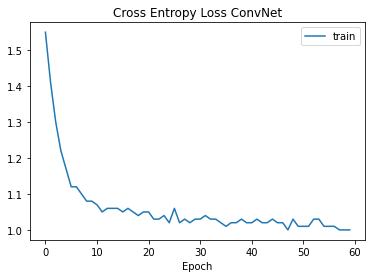

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


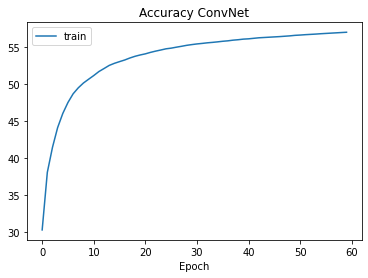

In [18]:
model_finetune=train(model_cnn, trainloader, 60, path = './', filename = 'convnet_basic.pth')

In [19]:
def test(net,testloader):
  loss=nn.CrossEntropyLoss()
  optimizer=optim.Adam(net.parameters(),lr=0.0001,weight_decay=0.001)
  device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
  net.to(device)
  loss_epoch=0
  test_loss_epoch=0
  t_ls=[]
  t_acc=[]
  total_vl=0
  correct_vl=0
  net.eval()
  with torch.no_grad():
    for x,y in testloader:
      
      x=x.to(device)
      y=y.to(device)
      ypred=net(x)
      testloss=loss(ypred,y)
      test_loss_epoch+=testloss.item() #loss.item() contains the loss of the entire mini-batch
      _, predicted = ypred.max(1)
      total_vl += y.size(0)
      correct_vl += predicted.eq(y).sum().item()
    test_ep_loss = round(test_loss_epoch/len(testloader),2)
    print('\tTest loss',test_ep_loss )
    test_ep_acc = round(100.*correct_vl/total_vl, 2)
    print('\tTest Accuracy',test_ep_acc)
    t_ls.append(test_ep_loss)
    t_acc.append(test_ep_acc)
  wandb.log({"finetune_test_loss": test_ep_loss})
  wandb.log({"finetune_test_accuracy": test_ep_acc})


In [20]:
test(model_finetune,test_stl_loader)

	Test loss 0.97
	Test Accuracy 60.02
